In [40]:
import random
import string
import numpy as np
from deap import base, creator, tools
from baseball_simulation import test, run_player_scenario_mc, run_player_scenario_mh, run_player_scenario_mc_standalone, Player

import multiprocessing
pool = multiprocessing.Pool()


In [7]:
test()

0.0 0.0
1.0205078125 1.2300000000000004
1.0205078125 1.1400000000000006


In [8]:
# Setup a runner for the genetic algorithm
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        print('Size of population {}'.format(len(population)))
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [10]:
## globals,

random.seed(11);
np.random.seed(121);


INDIVIDUAL_SIZE = 10
POPULATION_SIZE = 20 #200
N_ITERATIONS = 100
N_MATINGS = 50

In [11]:
toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)

## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [12]:
players =[Player([0.7, 0.3, 0.0, 0.0, 0.0, 0.0]),
          Player([0.5, 0.0, 0.0, 0.0, 0.0, 0.5]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([0.4, 0.0, 0.0, 0.0, 0.0, 0.6]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([0.6, 0.4, 0.0, 0.0, 0.0, 0.0]),
          Player([0.4, 0.0, 0.0, 0.0, 0.0, 0.6]),
          Player([0.8, 0.0, 0.0, 0.0, 0.0, 0.2]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([0.7, 0.3, 0.0, 0.0, 0.0, 0.0])]

players =[Player([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
          Player([0.5, 0.0, 0.0, 0.0, 0.0, 0.5]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([0.4, 0.0, 0.0, 0.0, 0.0, 0.6]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([0.6, 0.4, 0.0, 0.0, 0.0, 0.0]),
          Player([0.4, 0.0, 0.0, 0.0, 0.0, 0.6]),
          Player([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
          Player([0.5, 0.5, 0.0, 0.0, 0.0, 0.0]),
          Player([1.0, 0.0, 0.0, 0.0, 0.0, 0.0])]

initial_order = [0,1,2,3,4,5,6,7,8,9]

toolbox.register("evaluate", run_player_scenario_mc, players)
toolbox.register("map", pool.map)

# Do a single run and show results

In [18]:
df = run_player_scenario_mc_standalone(players,initial_order)
df = df[df.Inning == 4]
df, df['Runs'].mean()

(    Inning Runs Outs Inning Runs
 4        4   17    1           5
 8        4   20    1           5
 12       4   17    1           5
 16       4   18    0           5
 20       4   19    0           5
 ..     ...  ...  ...         ...
 384      4   20    2           5
 388      4   20    1           5
 392      4   18    1           5
 396      4   18    2           5
 400      4   20    2           5
 
 [100 rows x 4 columns], 19.14)

In [20]:
#Setup as an ordered crossover and some other parameters
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

In [21]:
#Do the run
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()

Size of population 20


In [22]:
fitnesses = sorted([ 
    (i, toolbox.evaluate(individual), individual) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])

fitnesses[:5]

[(3, 0.4800000000000004, [8, 4, 7, 2, 6, 3, 0, 1, 9, 5]),
 (10, 0.5300000000000011, [8, 4, 7, 2, 6, 3, 0, 1, 9, 5]),
 (13, 0.5500000000000007, [2, 9, 5, 7, 1, 3, 0, 6, 8, 4]),
 (1, 0.620000000000001, [5, 8, 0, 2, 3, 4, 1, 9, 6, 7]),
 (9, 0.620000000000001, [2, 9, 5, 7, 1, 3, 0, 6, 8, 4])]

<IPython.core.display.Javascript object>


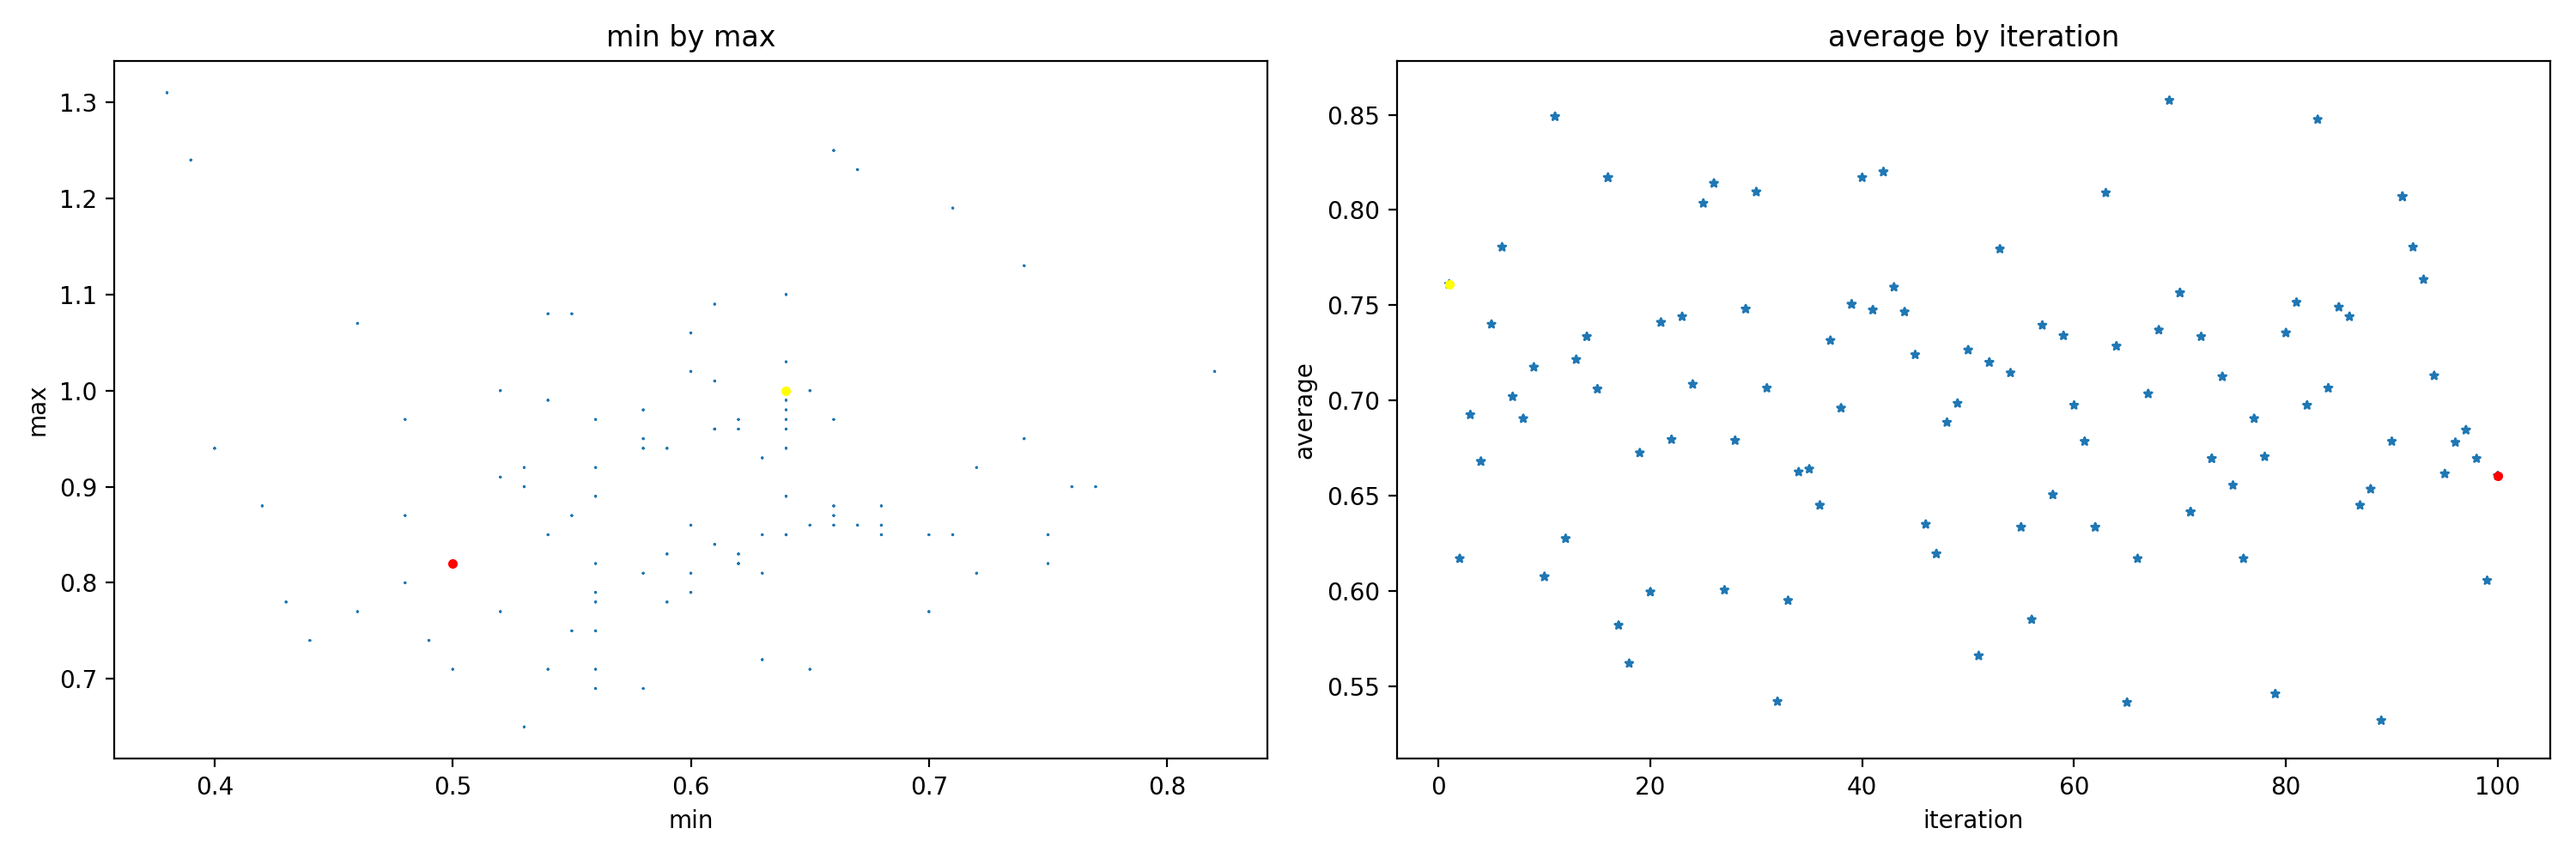

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='*', s=[ (s['std'] + 1) / 20 for s in stats ])

plt.title('min by max')
plt.xlabel('min')
plt.ylabel('max')

plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='*', s=[ (s['std'] + 1)*10 for s in stats ])

plt.title('average by iteration')
plt.xlabel('iteration')
plt.ylabel('average')

plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


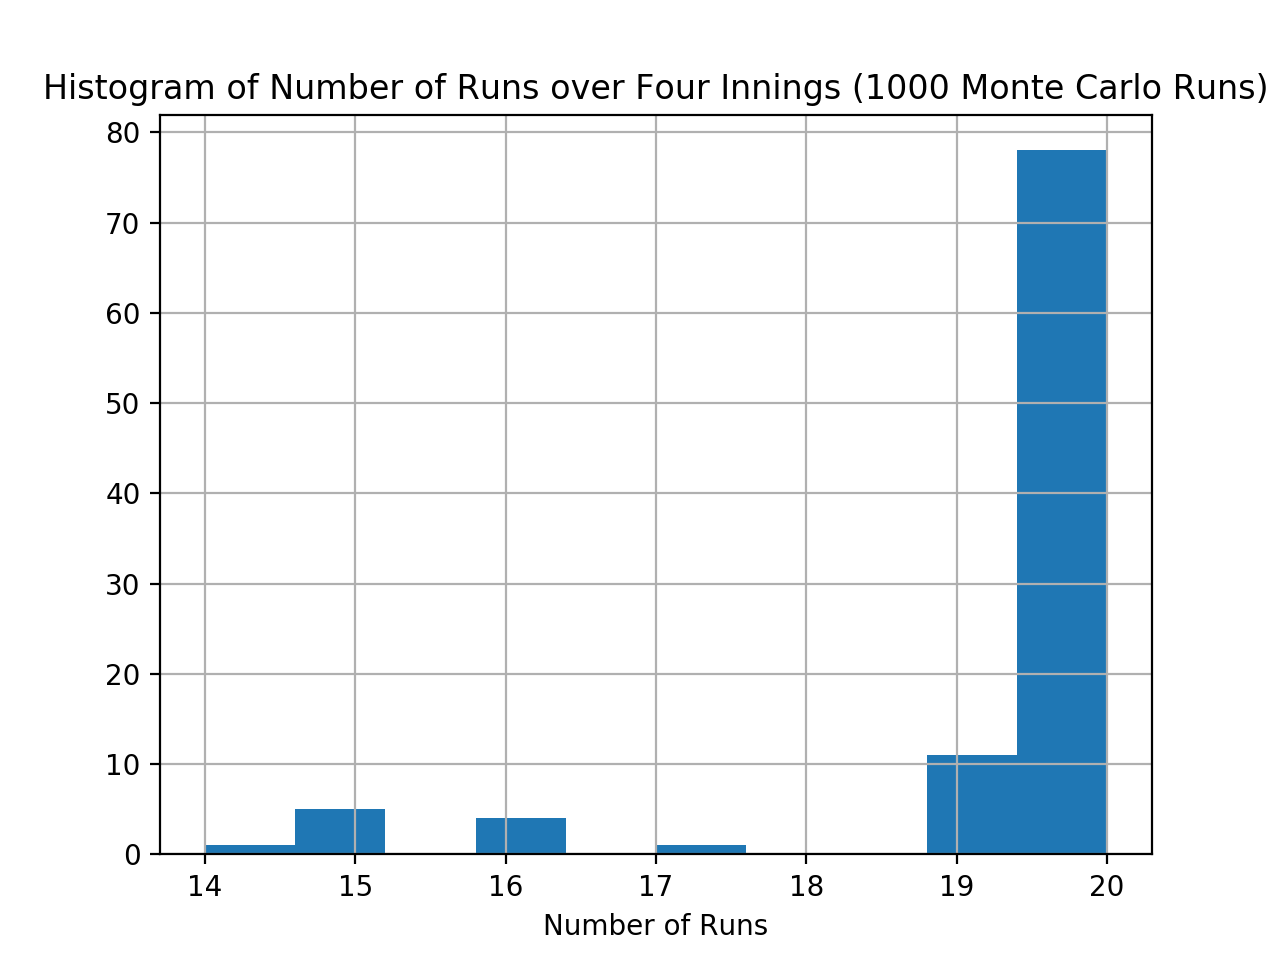

19.39


In [31]:
%matplotlib notebook 

df = run_player_scenario_mc_standalone(players,fitnesses[0][2])
ax = df[df.Inning == 4]['Runs'].hist() 
ax.set_xlabel('Number of Runs') 
ax.set_title('Histogram of Number of Runs over Four Innings (1000 Monte Carlo Runs)') 
print(df[df.Inning == 4]['Runs'].sum()/df[df.Inning == 4]['Runs'].count())

In [39]:
print('P', '1B ', '2B ', '3B ', 'HR ', 'SO ', 'BO ')
[print(i, players[i].p1b, players[i].p2b, players[i].p3b, players[i].phr, players[i].pso, players[i].pbo) for i in fitnesses[0][2]]

P 1B  2B  3B  HR  SO  BO 
8 0.5 0.5 0.0 0.0 0.0 0.0
4 0.5 0.5 0.0 0.0 0.0 0.0
7 1.0 0.0 0.0 0.0 0.0 0.0
2 0.5 0.5 0.0 0.0 0.0 0.0
6 0.4 0.0 0.0 0.0 0.0 0.6
3 0.4 0.0 0.0 0.0 0.0 0.6
0 1.0 0.0 0.0 0.0 0.0 0.0
1 0.5 0.0 0.0 0.0 0.0 0.5
9 1.0 0.0 0.0 0.0 0.0 0.0
5 0.6 0.4 0.0 0.0 0.0 0.0


[None, None, None, None, None, None, None, None, None, None]

# 